# KLRfome Wasserstein Kernel Tutorial

This notebook demonstrates using KLRfome with the **Wasserstein kernel** for geographic distribution regression.

> ✅ **Performance**: Wasserstein prediction is now **JIT-compiled** and vectorized! A 100×100 raster (10,000 pixels) takes just ~1-2 seconds.

## Wasserstein vs Mean Embedding

| Aspect | Mean Embedding (default) | Wasserstein |
|--------|-------------------------|-------------|
| **Similarity** | Inner product of mean embeddings | RBF on Sliced Wasserstein distance |
| **Best for** | Distributions differing by mean/location | Distributions with similar means but different shapes |
| **Speed** | Fast (RFF approximation) | Fast (JIT-compiled, ~1s for 10k pixels) |
| **Use case** | Standard spatial prediction | Multimodal/edge effects |

## When to Use Wasserstein

- Sites and background have **similar mean values** but **different distributional shapes**
- You have **multimodal** environmental signatures (e.g., edge habitats)
- Mean embedding gives **poor results** despite good data quality
- Shape/structure of distributions matters more than central tendency


## Setup


In [38]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import from_bounds
import geopandas as gpd
from shapely.geometry import Point

from klrfome import KLRfome, RasterStack
from klrfome.data.simulation import sim_trend, rescale_sim_raster, nlm_gaussianfield
from klrfome.visualization import plot_predictions

# Set random seeds for reproducibility
SEED = 123
np.random.seed(SEED)

print("KLRfome Wasserstein Kernel Tutorial")
print("=" * 40)


KLRfome Wasserstein Kernel Tutorial


## Step 1: Generate Simulated Data

Same as the quickstart - we create realistic simulated data with moderate correlations.


In [39]:
# Create REALISTIC simulated data with moderate correlations
# NOTE: Wasserstein is now JIT-compiled so we can use full-size rasters!
cols = 100
rows = 100
n_sites = 20
autocorr_range = 15

# Difficulty settings
mix_strength = 0.3
trend_power = 1.0
favor_threshold = 0.5
noise_level = 0.15

# Create site-likely rasters
s_var1r = nlm_gaussianfield(cols, rows, autocorr_range=autocorr_range, seed=SEED)
s_var1 = rescale_sim_raster(s_var1r, 60, 15)
s_var2 = rescale_sim_raster(s_var1r, 4, 2)
s_var3 = rescale_sim_raster(s_var1r, 6, 1.5)

# Create site-unlikely rasters
b_var1r = nlm_gaussianfield(cols, rows, autocorr_range=autocorr_range, seed=SEED + 1000)
b_var1 = rescale_sim_raster(b_var1r, 80, 15)
b_var2 = rescale_sim_raster(b_var1r, 5, 2)
b_var3 = rescale_sim_raster(b_var1r, 8, 1.5)

# Place sites in favorable areas
favorability_surface = s_var1r
trend_result = sim_trend(cols, rows, n=n_sites, size=6, seed=SEED,
                         favorable_surface=favorability_surface, favor_threshold=favor_threshold)
trend = trend_result['trend']
site_coords_pixels = trend_result['coords']

# Apply trend and combine
trend = np.power(trend, trend_power)
inv_trend = 1 - trend

var1 = (s_var1 * (trend * mix_strength + (1 - mix_strength) * 0.5)) + (b_var1 * (inv_trend * mix_strength + (1 - mix_strength) * 0.5))
var2 = (s_var2 * (trend * mix_strength + (1 - mix_strength) * 0.5)) + (b_var2 * (inv_trend * mix_strength + (1 - mix_strength) * 0.5))
var3 = (s_var3 * (trend * mix_strength + (1 - mix_strength) * 0.5)) + (b_var3 * (inv_trend * mix_strength + (1 - mix_strength) * 0.5))

# Add noise
np.random.seed(SEED)
var1 = var1 + np.random.normal(0, noise_level * np.std(var1), var1.shape)
var2 = var2 + np.random.normal(0, noise_level * np.std(var2), var2.shape)
var3 = var3 + np.random.normal(0, noise_level * np.std(var3), var3.shape)

# Create RasterStack
data = jnp.array([var1, var2, var3])
transform = from_bounds(0, 0, 1, 1, cols, rows)
band_names = ['var1', 'var2', 'var3']

raster_stack = RasterStack(data=data, transform=transform, crs="EPSG:4326", band_names=band_names)

# Convert pixel coords to geographic coords
site_points = []
for coord in site_coords_pixels:
    x, y = rasterio.transform.xy(transform, coord[1], coord[0])
    site_points.append(Point(x, y))

sites_gdf = gpd.GeoDataFrame(geometry=site_points, crs=raster_stack.crs)

print(f"Raster shape: {raster_stack.data.shape}")
print(f"Created {len(sites_gdf)} site locations")


Raster shape: (3, 100, 100)
Created 20 site locations


## Step 2: Initialize the Wasserstein Model

Create a KLRfome model with the **Wasserstein kernel**. Key parameters:

- `kernel_type='wasserstein'`: Use Sliced Wasserstein distance
- `n_projections`: Number of random projections (higher = more accurate, slower)
- `wasserstein_p`: Order of Wasserstein distance (1 or 2)
- `sigma`: RBF bandwidth on the Wasserstein distance


In [40]:
# Initialize Wasserstein model
# Now JIT-compiled for fast prediction!
model = KLRfome(
    sigma=0.5,                  # RBF bandwidth on Wasserstein distance
    lambda_reg=0.1,             # Regularization strength
    kernel_type='wasserstein',  # Use Wasserstein kernel!
    n_projections=100,          # Full projections (JIT makes this fast)
    wasserstein_p=2,            # p=2 (Euclidean), p=1 (Manhattan)
    window_size=5,              # 5×5 focal window
    seed=SEED
)

print("Wasserstein Model initialized with:")
print(f"  Kernel type: {model.kernel_type}")
print(f"  Sigma: {model.sigma}")
print(f"  Lambda: {model.lambda_reg}")
print(f"  n_projections: {model.n_projections}")
print(f"  wasserstein_p: {model.wasserstein_p}")
print(f"  Window size: {model.window_size}")


Wasserstein Model initialized with:
  Kernel type: wasserstein
  Sigma: 0.5
  Lambda: 0.1
  n_projections: 100
  wasserstein_p: 2
  Window size: 5


## Step 3: Prepare and Scale Training Data


In [41]:
# Prepare training data
raw_training_data = model.prepare_data(
    raster_stack=raster_stack,
    sites=sites_gdf,
    n_background=50,
    samples_per_location=25,  # Must be uniform for JIT optimization
    site_buffer=0.01,
    background_exclusion_buffer=0.02
)

# Scale the data (z-score normalization)
from klrfome.data.formats import SampleCollection, TrainingData

all_samples = np.vstack([np.array(c.samples) for c in raw_training_data.collections])
means = np.mean(all_samples, axis=0)
sds = np.std(all_samples, axis=0)
sds = np.where(sds < 1e-10, 1.0, sds)

print(f"Scaling parameters:")
print(f"  Means: {means}")
print(f"  Stds:  {sds}")

# Scale all collections
def scale_collection(coll):
    samples_array = jnp.array(coll.samples) if not isinstance(coll.samples, jnp.ndarray) else coll.samples
    scaled_samples = (samples_array - jnp.array(means)) / jnp.array(sds)
    return SampleCollection(samples=scaled_samples, label=coll.label, id=coll.id, metadata=coll.metadata)

scaled_collections = [scale_collection(c) for c in raw_training_data.collections]
training_data = TrainingData(
    collections=scaled_collections,
    feature_names=raw_training_data.feature_names,
    crs=raw_training_data.crs
)

print(f"\nTraining data prepared and scaled:")
print(f"  Total locations: {training_data.n_locations}")
print(f"  Sites: {training_data.n_sites}")
print(f"  Background: {training_data.n_background}")


Scaling parameters:
  Means: [66.79242    4.1683416  6.6682215]
  Stds:  [10.763793   1.3929642  1.1195948]

Training data prepared and scaled:
  Total locations: 70
  Sites: 20
  Background: 50


## Step 4: Fit the Wasserstein Model

The Wasserstein kernel computes pairwise Sliced Wasserstein distances between all training distributions, then applies an RBF kernel to create the similarity matrix.


### Optional: bucket-by-size acceleration
When sample counts vary a lot, pairwise SW distance computation can dominate fit time. If many sites share the same (or similar) sizes, you can speed this up by bucketing sizes and vectorizing within buckets.

- Exact mode (default): `bucket_tolerance=0` uses only exact size matches.
- Approx mode: `bucket_tolerance>0` groups nearby sizes and resamples each collection to the bucket median size using quantile interpolation.

Example (advanced, bypasses `model.fit`):
```python
from klrfome.kernels.wasserstein import WassersteinKernel
from klrfome.models.klr import KernelLogisticRegression

kernel = WassersteinKernel(
    sigma=model.sigma,
    n_projections=model.n_projections,
    p=model.wasserstein_p,
    seed=model.seed,
)
K = kernel.build_similarity_matrix(training_data.collections, bucket_tolerance=50)
fit = KernelLogisticRegression(lambda_reg=model.lambda_reg).fit(K, training_data.labels)
```


In [42]:
# Optional timing comparison for bucket_tolerance
from klrfome.kernels.wasserstein import WassersteinKernel
import time

kernel = WassersteinKernel(
    sigma=model.sigma,
    n_projections=model.n_projections,
    p=model.wasserstein_p,
    seed=model.seed,
)

for tol in [0, 50]:
    start = time.time()
    K = kernel.build_similarity_matrix(training_data.collections, bucket_tolerance=tol)
    elapsed = time.time() - start
    print(f"bucket_tolerance={tol}: {elapsed:.2f}s (K shape {K.shape})")


bucket_tolerance=0: 0.06s (K shape (70, 70))
bucket_tolerance=50: 0.03s (K shape (70, 70))


In [43]:
import time

# Fit the model (Wasserstein kernel is slower than mean embedding)
print("Fitting Wasserstein model...")
start_time = time.time()
model.fit(training_data)
fit_time = time.time() - start_time

# Check convergence
if model._fit_result.converged:
    print(f"✓ Model converged in {model._fit_result.n_iterations} iterations")
    print(f"  Fit time: {fit_time:.2f}s")
    print(f"  Final loss: {model._fit_result.final_loss:.6f}")
else:
    print(f"⚠ Model did not converge after {model._fit_result.n_iterations} iterations")

print(f"\nWasserstein similarity matrix shape: {model._similarity_matrix.shape}")
print(f"Similarity range: [{jnp.min(model._similarity_matrix):.3f}, {jnp.max(model._similarity_matrix):.3f}]")


Fitting Wasserstein model...
✓ Model converged in 5 iterations
  Fit time: 0.09s
  Final loss: 6.496127

Wasserstein similarity matrix shape: (70, 70)
Similarity range: [0.000, 1.000]


## Step 5: Predict Across the Landscape

Generate predictions using focal windows with the Wasserstein kernel.


In [44]:
# Scale the raster stack using SAME parameters as training data
print("Scaling raster stack for prediction...")
scaled_data = np.zeros_like(raster_stack.data)
for i in range(raster_stack.n_bands):
    scaled_data[i] = (raster_stack.data[i] - means[i]) / sds[i]

scaled_raster_stack = RasterStack(
    data=scaled_data,
    transform=raster_stack.transform,
    crs=raster_stack.crs,
    band_names=raster_stack.band_names
)

# Generate predictions (Wasserstein is now JIT-compiled for speed!)
# First batch includes JIT compilation (~1s), subsequent batches are very fast
print("\nGenerating predictions with Wasserstein kernel (JIT-optimized)...")
print(f"  Raster: {scaled_raster_stack.data.shape[1]}x{scaled_raster_stack.data.shape[2]} = {scaled_raster_stack.data.shape[1] * scaled_raster_stack.data.shape[2]} pixels")
print(f"  Training samples: {len(training_data.collections)}")
print(f"  Projections: {model.n_projections}")

start_time = time.time()
predictions = model.predict(
    raster_stack=scaled_raster_stack,
    batch_size=1000,  # Large batches work well with JIT
    show_progress=True
)
predict_time = time.time() - start_time

print(f"\nPrediction completed in {predict_time:.2f}s")
print(f"Prediction shape: {predictions.shape}")
print(f"Prediction range: [{jnp.min(predictions):.3f}, {jnp.max(predictions):.3f}]")
print(f"Mean probability: {jnp.mean(predictions):.3f}")


Scaling raster stack for prediction...

Generating predictions with Wasserstein kernel (JIT-optimized)...
  Raster: 100x100 = 10000 pixels
  Training samples: 70
  Projections: 100


Predicting (Wasserstein): 100%|██████████| 10/10 [00:00<00:00, 1531.89it/s]


Prediction completed in 0.07s
Prediction shape: (100, 100)


Prediction range: [0.041, 0.987]
Mean probability: 0.594


## Step 6: Model Evaluation


In [45]:
# Extract predictions at site and background locations
from klrfome.utils.validation import CM_quads, metrics, compute_roc_auc
from klrfome.visualization import plot_roc_curve
import pandas as pd

np.random.seed(SEED)

# Site predictions
transform = raster_stack.transform
site_predictions = []
for idx, row in sites_gdf.iterrows():
    geom = row.geometry
    row_idx, col = rasterio.transform.rowcol(transform, geom.x, geom.y)
    if 0 <= row_idx < predictions.shape[0] and 0 <= col < predictions.shape[1]:
        window_size = 2
        row_start = max(0, row_idx - window_size)
        row_end = min(predictions.shape[0], row_idx + window_size + 1)
        col_start = max(0, col - window_size)
        col_end = min(predictions.shape[1], col + window_size + 1)
        window_preds = predictions[row_start:row_end, col_start:col_end]
        site_predictions.extend(window_preds.flatten().tolist())

# Background predictions
n_background_samples = 500
background_predictions = []
for _ in range(n_background_samples):
    row = np.random.randint(0, predictions.shape[0])
    col = np.random.randint(0, predictions.shape[1])
    background_predictions.append(float(predictions[row, col]))

# Create evaluation dataframe
model_pred = pd.DataFrame({
    'pred': site_predictions + background_predictions,
    'presence': [1] * len(site_predictions) + [0] * len(background_predictions)
})

print(f"Evaluation samples: {len(site_predictions)} sites, {len(background_predictions)} background")


Evaluation samples: 500 sites, 500 background


In [46]:
# Compute metrics at multiple thresholds
thresholds = np.arange(0, 1.1, 0.1)
kstats = CM_quads(model_pred['pred'], model_pred['presence'], threshold=thresholds)

test_metrics = []
for _, row in kstats.iterrows():
    TP, TN, FP, FN = int(row['TP']), int(row['TN']), int(row['FP']), int(row['FN'])
    m = metrics(TP, TN, FP, FN)
    test_metrics.append({
        'Threshold': row['Threshold'],
        'TP': TP, 'FP': FP, 'TN': TN, 'FN': FN,
        'Sensitivity': m.get('Sensitivity', 0.0),
        'FPR': m.get('FPR', 0.0),
        'YoudensJ': m.get('Informedness', 0.0),
        'KG': m.get('KG', 0.0),
        'Precision': m.get('Precision', 0.0),
        'Specificity': m.get('Specificity', 0.0),
    })

auc_value = compute_roc_auc(model_pred['pred'], model_pred['presence'])
for result in test_metrics:
    result['AUC'] = auc_value

test_area_metrics = pd.DataFrame(test_metrics)

# Display metrics table
print("\nModel Evaluation Metrics at Different Thresholds:")
print("=" * 100)
display(test_area_metrics.round(3))



Model Evaluation Metrics at Different Thresholds:


,Threshold,TP,FP,TN,FN,Sensitivity,FPR,YoudensJ,KG,Precision,Specificity,AUC
0,0.0,500,500,0,0,1.000,1.000,0.000,0.000,0.500,0.000,0.706
1,0.1,500,455,45,0,1.000,0.910,0.090,0.090,0.524,0.090,0.706
2,0.2,500,414,86,0,1.000,0.828,0.172,0.172,0.547,0.172,0.706
3,0.3,500,391,109,0,1.000,0.782,0.218,0.218,0.561,0.218,0.706
4,0.4,495,370,130,5,0.990,0.740,0.250,0.253,0.572,0.260,0.706
5,0.5,491,344,156,9,0.982,0.688,0.294,0.299,0.588,0.312,0.706
6,0.6,464,301,199,36,0.928,0.602,0.326,0.351,0.607,0.398,0.706
7,0.7,421,258,242,79,0.842,0.516,0.326,0.387,0.620,0.484,0.706
8,0.8,361,192,308,139,0.722,0.384,0.338,0.468,0.653,0.616,0.706
9,0.9,206,107,393,294,0.412,0.214,0.198,0.481,0.658,0.786,0.706


# Find optimal threshold (maximizing Youden's J)
optimal_idx = test_area_metrics['YoudensJ'].idxmax()
optimal_threshold = test_area_metrics.loc[optimal_idx, 'Threshold']
optimal_metrics = test_area_metrics.loc[optimal_idx]

print(f"\n{'='*60}")
print(f"WASSERSTEIN MODEL EVALUATION - OPTIMAL THRESHOLD")
print(f"{'='*60}")
print(f"\nOptimal Threshold (maximizing Youden's J): {optimal_threshold:.1f}")
print(f"  Sensitivity: {optimal_metrics['Sensitivity']:.3f}")
print(f"  FPR: {optimal_metrics['FPR']:.3f}")
print(f"  Youden's J: {optimal_metrics['YoudensJ']:.3f}")
print(f"  Kvamme Gain: {optimal_metrics['KG']:.3f}")
print(f"  AUC: {optimal_metrics['AUC']:.3f}")


## Step 7: Visualize Results


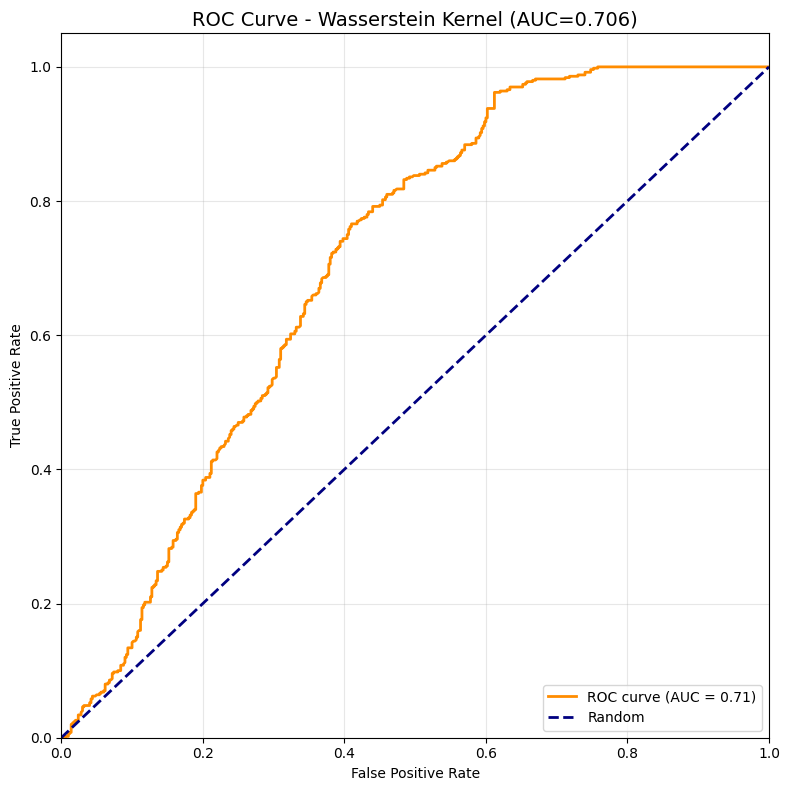

In [47]:
# ROC Curve
fig, ax = plot_roc_curve(model_pred['pred'], model_pred['presence'], figsize=(8, 8))
ax.set_title(f'ROC Curve - Wasserstein Kernel (AUC={auc_value:.3f})', fontsize=14)
plt.show()


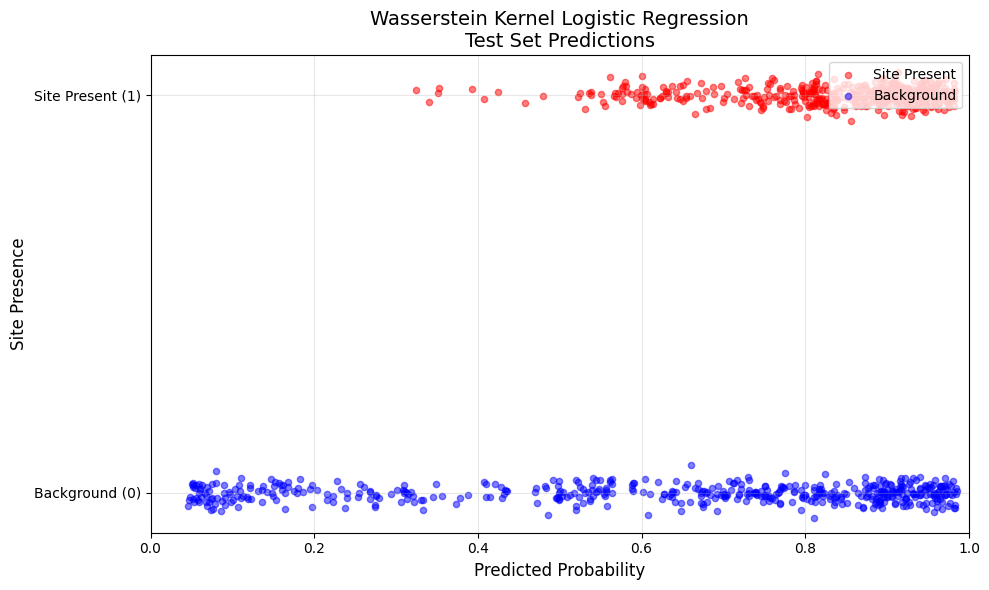

In [48]:
# Prediction Distribution
fig, ax = plt.subplots(figsize=(10, 6))

site_preds = model_pred[model_pred['presence'] == 1]['pred']
bg_preds = model_pred[model_pred['presence'] == 0]['pred']

np.random.seed(SEED)
y_sites = np.ones(len(site_preds)) + np.random.normal(0, 0.02, len(site_preds))
y_bg = np.zeros(len(bg_preds)) + np.random.normal(0, 0.02, len(bg_preds))

ax.scatter(site_preds, y_sites, alpha=0.5, label='Site Present', color='red', s=20)
ax.scatter(bg_preds, y_bg, alpha=0.5, label='Background', color='blue', s=20)

ax.set_xlabel('Predicted Probability', fontsize=12)
ax.set_ylabel('Site Presence', fontsize=12)
ax.set_title('Wasserstein Kernel Logistic Regression\nTest Set Predictions', fontsize=14)
ax.set_ylim(-0.1, 1.1)
ax.set_xlim(0, 1)
ax.set_yticks([0, 1])
ax.set_yticklabels(['Background (0)', 'Site Present (1)'])
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


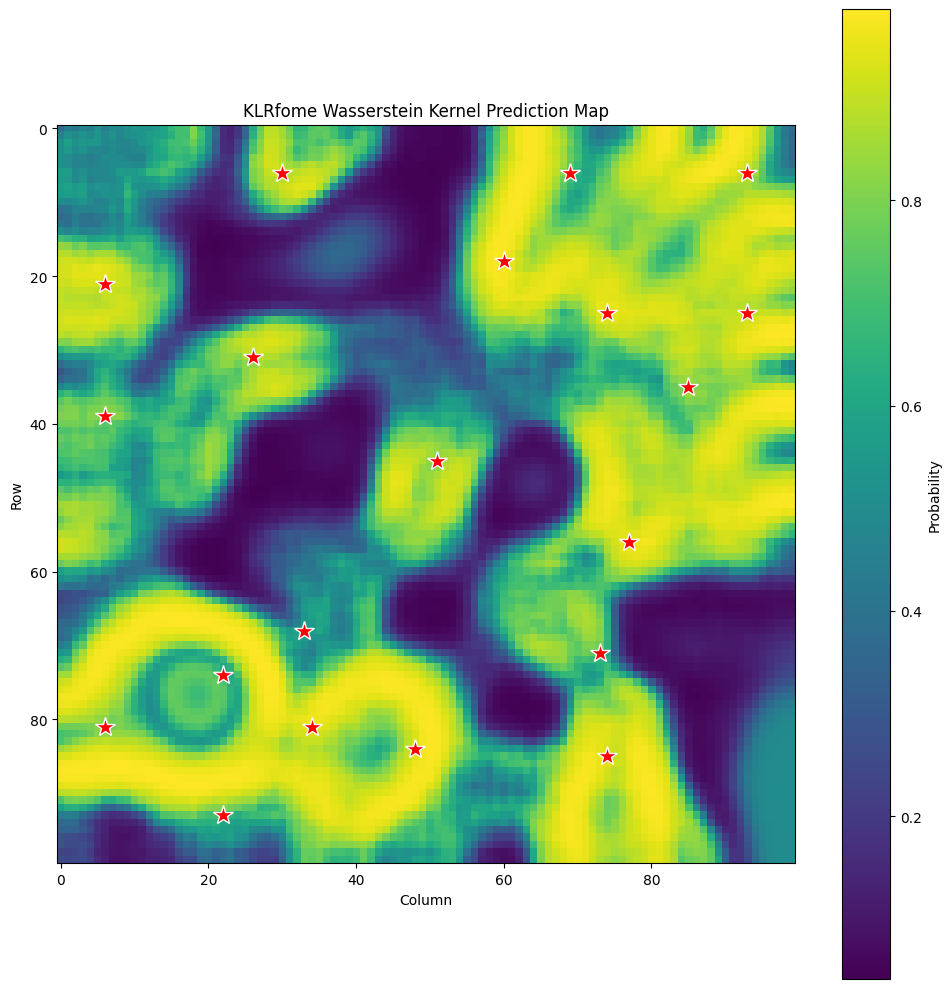

In [49]:
# Prediction Map
fig, ax = plot_predictions(
    predictions,
    sites=sites_gdf,
    figsize=(10, 10),
    cmap='viridis',
    title='KLRfome Wasserstein Kernel Prediction Map'
)

# Overlay site locations
for idx, row in sites_gdf.iterrows():
    geom = row.geometry
    row_idx, col = rasterio.transform.rowcol(transform, geom.x, geom.y)
    if 0 <= row_idx < predictions.shape[0] and 0 <= col < predictions.shape[1]:
        ax.plot(col, row_idx, 'r*', markersize=15, markeredgecolor='white', markeredgewidth=1)

plt.tight_layout()
plt.show()


## Summary

This tutorial demonstrated using KLRfome with the **Wasserstein kernel**:

1. **Initialize with `kernel_type='wasserstein'`**
2. **Set `n_projections`** (more = accurate, now fast with JIT!)
3. **Set `wasserstein_p`** (p=2 standard, p=1 robust to outliers)
4. The rest of the workflow is identical to mean embedding

### Wasserstein Kernel Parameters

| Parameter | Value | Description |
|-----------|-------|-------------|
| `n_projections` | 100 | Number of random 1D projections |
| `wasserstein_p` | 2 | Order (1=Manhattan, 2=Euclidean) |
| `sigma` | 0.5 | RBF bandwidth on Wasserstein distance |
| `window_size` | 5 | Focal window size |

### When to Choose Wasserstein over Mean Embedding

- Similar means but different distributional shapes
- Multimodal environmental signatures
- Edge habitat effects
- Mean embedding produces poor results

### Performance (JIT-Optimized)

Wasserstein prediction is now **JIT-compiled and vectorized**:

| Raster Size | Time | Notes |
|-------------|------|-------|
| 40×40 (1,600 px) | ~0.01s | After JIT warmup |
| 100×100 (10,000 px) | ~1s | First run includes JIT compile |
| Larger rasters | Linear scaling | ~0.06s per 1000 pixels |

**Key optimization**: Training collections must have **uniform sample sizes** for the JIT-optimized path. The `prepare_data()` method ensures this automatically.
